In [1]:
import torch
import numpy as np

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **NEURAL NETWORK**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, layer_size):
        super(PINN, self).__init__()
 
        self.fc1 = nn.Linear(input_dim, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, output_dim)
 
 
 
    def forward(self, input_grid, input_0, input_lb, input_ub):
        _, _, _, _, f_u_predict, f_v_predict = self.forward_it(input_grid.float(), True)
        predict_u_0, predict_v_0, _, _, _, _ = self.forward_it(input_0.float(), False)
        predict_u_lb, predict_v_lb, predict_u_x_lb, predict_v_x_lb, _, _ = self.forward_it(input_lb.float(), False)
        predict_u_ub, predict_v_ub, predict_u_x_ub, predict_v_x_ub, _, _ = self.forward_it(input_ub.float(), False)
        return f_u_predict, f_v_predict, predict_u_0, predict_v_0, predict_u_lb, predict_v_lb, predict_u_x_lb, predict_v_x_lb, predict_u_ub, predict_v_ub, predict_u_x_ub, predict_v_x_ub
 
 
 
    def forward_it(self, X, flag_pinn):
        u_xx, v_xx, u_t, v_t, f_u, f_v = None, None, None, None, None, None 

        batch_size = X.shape[0]
        x, t = X[:, :1], X[:, 1:]
        x.requires_grad_(True)
        t.requires_grad_(True)
 
        s = nn.Tanh()(self.fc1(torch.cat((x, t), 1)))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        uv = self.fc4(s)
 
        u = uv[:, :1]
        v = uv[:, 1:]
 
        u_x = autograd.grad(u, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
        v_x = autograd.grad(v, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
 
        if flag_pinn:
            u_t = autograd.grad(u, t, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
            v_t = autograd.grad(v, t, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
            u_xx = autograd.grad(u_x, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
            v_xx = autograd.grad(v_x, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
            f_u = u_t.float() + 0.5 * v_xx.float() + (u ** 2 + v ** 2) * v
            f_v = v_t.float() - 0.5 * u_xx.float() - (u ** 2 + v ** 2) * u           
 
        return u, v, u_x, v_x, f_u, f_v
 
 
 
    def predict(self, X):
        s = nn.Tanh()(self.fc1(X))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        uv = self.fc4(s)
 
        u = uv[:, :1]
        v = uv[:, 1:]
        return u, v

# **OPTIMIZATION**

In [6]:
from torch.optim import LBFGS
from time import time
from tqdm.notebook import tqdm as tqdm

In [7]:
class Train():
    def __init__(self, network, grid_input, input_0, target_u_0, target_v_0, l_boundary_input, u_boundary_input):
        self.net = network
 
        self.lbfgs_optim = LBFGS(self.net.parameters(), lr=1, max_iter=50000, line_search_fn='strong_wolfe')
    
        self.train_input_grid = grid_input.to(device) 
        self.train_input_0, self.train_target_u_0, self.train_target_v_0 = input_0.to(device), target_u_0.to(device), target_v_0.to(device)
        self.train_input_lb, self.train_input_ub = l_boundary_input.to(device), u_boundary_input.to(device)
 
 
    def train(self):
        start_time = time()
        self.train_iteration(self.train_input_grid, self.train_input_0, self.train_target_u_0, self.train_target_v_0, self.train_input_lb, self.train_input_ub)        
        end_time = time()
        print('Time:', end_time - start_time)     
 
 
 
    def train_iteration(self, input_grid, input_0, target_u_0, target_v_0, input_lb, input_ub):
        
        def closure():
            if torch.is_grad_enabled():
                self.lbfgs_optim.zero_grad()
            f_u_predict, f_v_predict, predict_u_0, predict_v_0, predict_u_lb, predict_v_lb, predict_u_x_lb, predict_v_x_lb, predict_u_ub, predict_v_ub, predict_u_x_ub, predict_v_x_ub \
                = self.net(input_grid, input_0, input_lb, input_ub)
            loss = self.loss_function(predict_u_0, target_u_0, predict_v_0, target_v_0, predict_u_lb, predict_u_ub, predict_v_lb, predict_v_ub, predict_u_x_lb, predict_u_x_ub, predict_v_x_lb, predict_v_x_ub, f_u_predict, f_v_predict)
            if loss.requires_grad:
                loss.backward()            
            return loss


        self.lbfgs_optim.step(closure)
 
 
    def loss_function(self, predict_u_0, target_u_0, predict_v_0, target_v_0, predict_u_lb, predict_u_ub, predict_v_lb, predict_v_ub, predict_u_x_lb, predict_u_x_ub, predict_v_x_lb, predict_v_x_ub, f_u_predict, f_v_predict):
        loss_fn = nn.MSELoss()
        
        loss = loss_fn(predict_u_0.double(), target_u_0.double()) + loss_fn(predict_v_0.double(), target_v_0.double()) + loss_fn(predict_u_lb.double(), predict_u_ub.double()) + loss_fn(predict_v_lb.double(), predict_v_ub.double()) + \
            loss_fn(predict_u_x_lb.double(), predict_u_x_ub.double()) + loss_fn(predict_v_x_lb.double(), predict_v_x_ub.double()) + loss_fn(f_u_predict.double(), torch.zeros((f_u_predict.shape[0], 1)).double().to(device)) + \
            loss_fn(f_v_predict.double(), torch.zeros((f_v_predict.shape[0], 1)).double().to(device))
 
        return loss


# **MAIN**

## DATA PREPERATION

In [8]:
import scipy.io

FUNCTIONS FOR DATA MANAGEMENT

In [9]:
def create_passable_data(x, t, u=None, v=None):
    N_x = x.shape[0]
    N_t = t.shape[0]
    passable_input = []
    passable_target_u = []
    passable_target_v = []
 
    for nt in range(N_t):
        for nx in range(N_x):
            _t = t[nt, 0]
            _x = x[nx, 0]
            _passable_input = np.array([_x, _t])[np.newaxis]
            passable_input.append(_passable_input)
            if (u is not None) and (v is not None):
                _u = u[nt, nx]
                _v = v[nt, nx]
                _passable_target_u = np.array(_u)
                _passable_target_v = np.array(_v)
                passable_target_u.append(_passable_target_u)
                passable_target_v.append(_passable_target_v)
  
    passable_input = np.array(passable_input)
    passable_input = torch.tensor(passable_input).view(N_t * N_x, 2)
 
    if (u is not None) and (v is not None):
        passable_target_u = np.array(passable_target_u)
        passable_target_u = torch.tensor(passable_target_u).view(N_t * N_x, 1)
 
        passable_target_v = np.array(passable_target_v)
        passable_target_v = torch.tensor(passable_target_v).view(N_t * N_x, 1)
 
    return passable_input, passable_target_u, passable_target_v

COLLECTING THE DATA

In [11]:
data = scipy.io.loadmat('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/main/Data/NLS.mat')
 
t_data = data['tt'].T  # SHAPE (201, 1)
x_data = data['x'].T # SHAPE (256,1)
 
h_data = data['uu'].T  # SHAPE (201, 256)
u_data = np.real(h_data)
v_data = np.imag(h_data)
 
lb = np.array([-5.0, 0.0]) # (spacial lower bound, time lower bound)
ub = np.array([5.0, np.pi/2]) # (spacial upper bound, time upper bound)

CREATING PASSABLE DATA

In [12]:
grid_input, grid_target_u, grid_target_v = create_passable_data(x_data, t_data, u_data, v_data)
print('GRID:', grid_input.shape)

l_boundary_input, l_boundary_target_u, l_boundary_target_v = create_passable_data(lb[0][np.newaxis][np.newaxis], t_data, u_data, v_data)
print('L BOUNDARY:', l_boundary_input.shape, l_boundary_target_u.shape, l_boundary_target_v.shape)

u_boundary_input, u_boundary_target_u, u_boundary_target_v = create_passable_data(ub[0][np.newaxis][np.newaxis], t_data, u_data, v_data)
print('U BOUNDARY:', u_boundary_input.shape, u_boundary_target_u.shape, u_boundary_target_v.shape)

input_0, target_u_0, target_v_0 = create_passable_data(x_data, lb[1][np.newaxis][np.newaxis], u_data, v_data)
print('INIT', input_0.shape, target_u_0.shape, target_v_0.shape)

GRID: torch.Size([51456, 2])
L BOUNDARY: torch.Size([201, 2]) torch.Size([201, 1]) torch.Size([201, 1])
U BOUNDARY: torch.Size([201, 2]) torch.Size([201, 1]) torch.Size([201, 1])
INIT torch.Size([256, 2]) torch.Size([256, 1]) torch.Size([256, 1])


-> reducing passable data size

In [13]:
idx = np.arange(u_boundary_input.shape[0])
temp = np.random.permutation(idx)[:50]
l_boundary_input, u_boundary_input = l_boundary_input[temp, :].view(-1, 2), u_boundary_input[temp, :].view(-1, 2)

idx = np.arange(input_0.shape[0])

temp = np.random.permutation(idx)[:50]
input_0, target_u_0, target_v_0 = input_0[temp, :].view(-1, 2), target_u_0[temp, :].view(-1, 1), target_v_0[temp, :].view(-1, 1)

 
print('L BOUNDARY:', l_boundary_input.shape)
print('U BOUNDARY:', u_boundary_input.shape)
print('0:', input_0.shape, target_u_0.shape, target_v_0.shape)

L BOUNDARY: torch.Size([50, 2])
U BOUNDARY: torch.Size([50, 2])
0: torch.Size([50, 2]) torch.Size([50, 1]) torch.Size([50, 1])


## TRAINING

INITIALIZE NETWORK

In [14]:
input_dim, output_dim, layer_size = 2, 2, 100
net = PINN(input_dim, output_dim, layer_size).to(device)

TRAINING NETWORK

In [15]:
train = Train(net, grid_input, input_0, target_u_0, target_v_0, l_boundary_input, u_boundary_input)

In [16]:
train.train()

Time: 1565.5598545074463


## PLOTTING

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

PLOTTING FUNCTIONS

In [18]:
def plot_grid(u_plot, t_data, X_grid, T_grid, string_title, lb_input=None, ub_input=None, input_0=None, t_index_low=None, t_index_mid=None, t_index_high=None):
    fig = plt.subplots(figsize=(8, 4))
    plt.contourf(T_grid, X_grid, u_plot, 1000, cmap=plt.get_cmap('Spectral'))
    plt.colorbar()
    plt.ylabel(r'$x$')
    plt.xlabel(r'$t$')
    plt.title(string_title, fontsize = 15) 

    try:
        fig[1].set_ylim(x_data.min(), x_data.max())
        fig[1].plot(lb_input[:,1], lb_input[:,0], 'kx', label = 'Data (%d points)' % (lb_input.shape[0]), markersize = 6, clip_on = False)
        fig[1].plot(ub_input[:,1], ub_input[:,0], 'kx', label = 'Data (%d points)' % (ub_input.shape[0]), markersize = 6, clip_on = False)
        fig[1].plot(input_0[:,1], input_0[:,0], 'kx', label = 'Data (%d points)' % (input_0.shape[0]), markersize = 6, clip_on = False)
        
        
        line = np.linspace(x_data.min(), x_data.max(), 2)[:,None]
        fig[1].plot(t_data[t_index_low]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_mid]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_high]*np.ones((2,1)), line, 'k--', linewidth = 1) 
    except Exception:
        pass    
    

    plt.show()
    plt.draw()
    #fig[0].savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Schrodinger Continuous Inference/' + string_title.format(1000), bbox_inches='tight')
    plt.close()

def plot_time_step(x_data, t_data, u_data, u_pred, t_index, x_lb, x_ub, y_lb, y_ub):



    fig = plt.subplots(figsize=(2.6, 2))
    fig[1].plot(x_data, u_data[t_index,:], 'b-', linewidth = 2, label = 'Exact')       
    fig[1].plot(x_data, u_pred[t_index,:], 'r--', linewidth = 2, label = 'Prediction')
    fig[1].set_xlabel('$x$')
    fig[1].set_ylabel('$|h(t,x)|$')  
    title = '$t = %.2f' % t_data[t_index].item() + '$'
    fig[1].set_title(title, fontsize = 15)
    fig[1].set_xlim([x_lb, x_ub])
    fig[1].set_ylim([y_lb, y_ub])
    fig[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)
    plt.show()
    #fig[1].figure.savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Schrodinger Continuous Inference/target_v_pred_t%.2f' % t_data[t_index].item() + '.png', bbox_inches='tight')


PLOTTING TARGET DATA

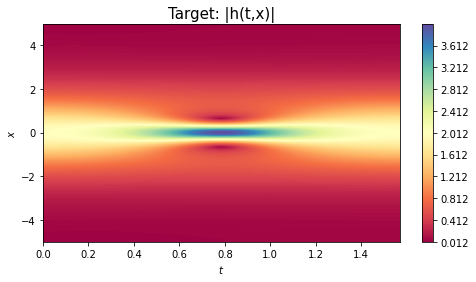

In [19]:
X, T = np.meshgrid(x_data, t_data)
h_target = (u_data**2 + v_data**2)**0.5
plot_grid(h_target, t_data, X, T, 'Target: |h(t,x)|')

PLOTTING PREDICTED DATA

In [20]:
u_predict, v_predict = net.predict(grid_input.to(device).float())

h_predict = (u_predict.cpu().detach().view(201, 256).numpy()**2 + v_predict.cpu().detach().view(201, 256).numpy()**2)**0.5

snapshot_index_low=int(3*t_data.shape[0]/10)
snapshot_index_middle=int(t_data.shape[0]/2)
snapshot_index_high=int(7*t_data.shape[0]/10)

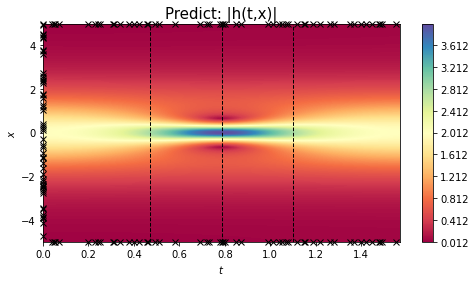

In [21]:
plot_grid(h_predict, t_data, X, T, 'Predict: |h(t,x)|', l_boundary_input, u_boundary_input, input_0, snapshot_index_low, snapshot_index_middle, snapshot_index_high)

TARGET VS PREDICT AT SPECIFIC TIME STEPS


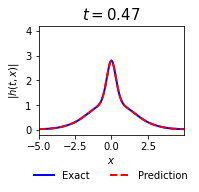

In [22]:
plot_time_step(x_data, t_data, h_target, h_predict, snapshot_index_low, x_data.min(), x_data.max(), h_target.min()- 0.05* h_target.max(), h_target.max()*1.05)

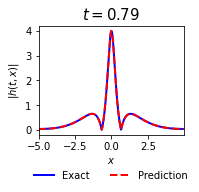

In [23]:
plot_time_step(x_data, t_data, h_target, h_predict, snapshot_index_middle, x_data.min(), x_data.max(), h_target.min()- 0.05* h_target.max(), h_target.max()*1.05)

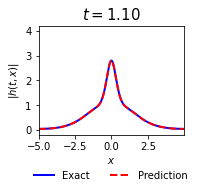

In [24]:
plot_time_step(x_data, t_data, h_target, h_predict, snapshot_index_high, x_data.min(), x_data.max(), h_target.min()- 0.05* h_target.max(), h_target.max()*1.05)

##ERROR


In [25]:
criterion = nn.MSELoss()
Error = criterion( u_predict.cpu(), grid_target_u) + criterion(v_predict.cpu(), grid_target_v)

print('L2 Norm Error:', Error.item())

Error_relative = Error / (torch.mean(torch.abs(grid_target_u) + torch.abs(grid_target_v)))
print('Relative L2 Norm Error:', Error_relative.item())

L2 Norm Error: 9.665164540019174e-05
Relative L2 Norm Error: 0.00012988360780483987
